In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [52]:
data_dir = r'C:\Users\elbai\PycharmProjects\West_Coast_Regional_Datathon_2020\data'

In [2]:
data_dir = "D:\\Downloads\\citadel-datathon-fall-2020"

In [3]:
tag_threshold = 1000

In [4]:
from datetime import datetime

tag_df = pd.read_csv(data_dir + '/movie_lense/tags.csv')
tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'], unit='s')
tag_df.head(10)
tag_df.describe()

,userId,movieId
count,1.108997e+06,1.108997e+06
mean,1.248016e+05,5.492109e+04
std,7.726964e+04,5.618123e+04
min,1.400000e+01,1.000000e+00
25%,7.340600e+04,3.362000e+03
50%,1.030130e+05,4.374400e+04
75%,1.883600e+05,9.682100e+04
max,2.832210e+05,1.938680e+05


In [5]:
print(tag_df.head(10))
tag_df = tag_df.groupby('tag').filter(lambda x: len(x) > tag_threshold)
tag_count = tag_df['tag'].value_counts()
print(tag_count)

   userId  movieId             tag           timestamp
0      14      110            epic 2015-09-25 02:35:38
1      14      110        Medieval 2015-09-25 02:35:32
2      14      260          sci-fi 2015-09-13 18:36:50
3      14      260    space action 2015-09-13 18:37:01
4      14      318    imdb top 250 2015-09-18 22:26:35
5      14      318         justice 2015-09-18 22:26:32
6      14      480       Dinosaurs 2015-09-25 02:36:03
7      14      593  psychothriller 2015-10-05 03:04:46
8      14     1682      philosophy 2015-09-18 22:25:58
9      14     1682    surveillance 2015-09-18 22:26:07
sci-fi         9400
atmospheric    6430
action         6219
comedy         5923
surreal        5299
               ... 
futuristic     1008
intelligent    1008
racism         1004
Brad Pitt      1003
military       1001
Name: tag, Length: 137, dtype: int64


In [6]:
#changed to tuple
ntag_df = tag_df.groupby('movieId').agg(lambda x: x.tolist()).drop(['userId', 'timestamp'],axis=1)
# tag_count = tag_df['tag'].value_counts()
ntag_df

,tag
movieId,
1,"[comedy, family, friendship, adventure, animat..."
2,"[fantasy, adapted from:book, based on a book, ..."
3,"[sequel, comedy, sequel, funny, CLV]"
4,"[based on novel or book, revenge, CLV]"
5,"[remake, family, sequel, family, humorous, CLV..."
...,...
193679,[drama]
193731,[based on a book]
193837,"[aliens, anime]"


In [7]:
tagged_movies = pd.get_dummies(tag_df[['movieId', 'tag']], prefix='tag', columns=['tag']).groupby('movieId').max()

#tagged_movies = pd.get_dummies(tag_df[['movieId', 'tag']], columns=['tag']).groupby('movieId').max()

In [8]:
ratings_csv = pd.read_csv(data_dir + '/movie_lense/ratings.csv')

In [9]:

tagged_movies['rating_total'] = ratings_csv.groupby('movieId')['rating'].sum()
tagged_movies['rating_count'] = ratings_csv.groupby('movieId')['rating'].count()
print(tagged_movies)

         tag_Action  tag_BD-R  tag_Betamax  tag_Brad Pitt  tag_CLV  \
movieId                                                              
1                 0         0            0              0        1   
2                 0         0            0              0        1   
3                 0         0            0              0        1   
4                 0         0            0              0        1   
5                 0         0            0              0        1   
...             ...       ...          ...            ...      ...   
193679            0         0            0              0        0   
193731            0         0            0              0        0   
193837            0         0            0              0        0   
193864            0         0            0              0        0   
193868            0         0            0              0        0   

         tag_Criterion  tag_Disney  tag_Johnny Depp  tag_Leonardo DiCaprio  \
movieId    

In [10]:
#tagged_movies.to_pickle('./tagged_movies.pkl')
#tagged_movies = pd.read_pickle('./tagged_movies.pkl')
tagged_movies = tagged_movies[tagged_movies['rating_count'] > 0]
tagged_movies['rating_avg'] = tagged_movies.apply(lambda x: x.rating_total/x.rating_count, axis=1)
tagged_movies.dropna()
tagged_movies.to_pickle('./tagged_movies_w_rating_avg.pkl')

Number of mislabeled points out of a total 13645 points : 8068


C:\Users\Twangybeast\Miniconda3\envs\citadel-datathon-fall-2020\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

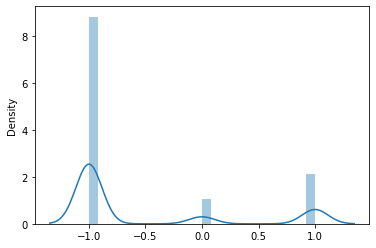

In [11]:
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
input = tagged_movies.drop(columns=['rating_total', 'rating_count', 'rating_avg'])
rating_avg = tagged_movies.rating_avg
[lower, upper] = rating_avg.quantile([0.3, 0.7])
def rating_to_sentiment(rating):
    if rating < lower:
        sentiment = -1
    elif rating > upper:
        sentiment = 1
    else:
        sentiment = 0
    return sentiment
output = rating_avg.apply(lambda x: rating_to_sentiment(x))
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.5, random_state=0)
gnb = naive_bayes.GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

sns.distplot(y_pred)

In [ ]:
from sklearn import svm

clf = svm.NuSVC(gamma='auto')
y_pred_svm = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

sns.distplot(y_pred)

In [ ]:
sns.distplot(rating_avg)
print(rating_avg.quantile([0.3, 0.7]))
print(rating_avg.describe())

In [ ]:
sns.distplot(rating_avg)
print(rating_avg.quantile([0.3, 0.7]))
print(rating_avg.describe())

In [40]:
input = tagged_movies.drop(columns=['rating_total', 'rating_count', 'rating_avg'])
rating_avg = tagged_movies.rating_avg
def rating_to_sentiment(rating):
    if rating < 3:
        sentiment = -1
    elif rating < 3.5:
        sentiment = 0
    else:
        sentiment = 1
    return sentiment
output = rating_avg.apply(lambda x: rating_to_sentiment(x)) + 1
X_train, X_test, y_train, y_test = train_test_split(input.values, output, test_size=0.5, random_state=500)

In [47]:
gnb = naive_bayes.CategoricalNB()
#gnb = naive_bayes.GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
total = X_test.shape[0]
correct = (y_test == y_pred).sum()
print("acc/correct/total: %f/%d/%d" % (correct/total, correct, total))

acc/correct/total: 0.469623/6408/13645


In [55]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import neighbors
from sklearn import neural_network
from sklearn import svm

In [16]:
clf = ensemble.RandomForestClassifier(10)
y_pred = clf.fit(X_train, y_train).predict(X_test)
total = X_test.shape[0]
correct = (y_test == y_pred).sum()
print("acc/correct/total: %f/%d/%d" % (correct/total, correct, total))

acc/correct/total: 0.448882/2450/5458


In [18]:
output = rating_avg
X_train, X_test, y_train, y_test = train_test_split(input.values, output, test_size=0.2, random_state=500)

In [19]:
model = linear_model.LinearRegression()
y_pred = model.fit(X_train, y_train).predict(X_test)
print("MSE/R^2/MAE: %f/%f/%f" % \
      (metrics.mean_squared_error(y_test, y_pred), 
       metrics.r2_score(y_test, y_pred), 
       metrics.mean_absolute_error(y_test, y_pred)))

MSE/R^2/MAE: 0.336584/0.146043/0.429874


In [20]:
import spacy
# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_md')



In [21]:
tags = []
for tag in input.columns:
    tag = tag.split('_')[1]
    tags.append(tag)

In [30]:
tag_embds = []
for tag in tags:
    v= nlp(tag).vector
    v /= np.sqrt(v.dot(v))
    tag_embds.append(v.reshape(-1, 1))

In [32]:
tag_embedder = np.concatenate(tag_embds, axis=1)


(300, 137)

In [33]:
input.values

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [48]:
input2 = (tag_embedder @ input.values.T)
input2 = input2 / np.linalg.norm(input2)
X_train, X_test, y_train, y_test = train_test_split(input.values, output, test_size=0.5, random_state=500)

In [49]:
model = neighbors.KNeighborsClassifier()
y_pred = model.fit(X_train, y_train).predict(X_test)
total = X_test.shape[0]
correct = (y_test == y_pred).sum()
print("acc/correct/total: %f/%d/%d" % (correct/total, correct, total))

acc/correct/total: 0.409161/5583/13645


In [50]:
model = linear_model.LogisticRegression(max_iter=200)
y_pred = model.fit(X_train, y_train).predict(X_test)
total = X_test.shape[0]
correct = (y_test == y_pred).sum()
print("acc/correct/total: %f/%d/%d" % (correct/total, correct, total))

acc/correct/total: 0.475559/6489/13645


In [51]:
model = ensemble.AdaBoostClassifier()
y_pred = model.fit(X_train, y_train).predict(X_test)
total = X_test.shape[0]
correct = (y_test == y_pred).sum()
print("acc/correct/total: %f/%d/%d" % (correct/total, correct, total))

acc/correct/total: 0.463979/6331/13645


In [54]:
model = neural_network.MLPClassifier()
y_pred = model.fit(X_train, y_train).predict(X_test)
total = X_test.shape[0]
correct = (y_test == y_pred).sum()
print("acc/correct/total: %f/%d/%d" % (correct/total, correct, total))

acc/correct/total: 0.447270/6103/13645


C:\Users\Twangybeast\Miniconda3\envs\citadel-datathon-fall-2020\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
model = svm.SVC()
y_pred = model.fit(X_train, y_train).predict(X_test)
total = X_test.shape[0]
correct = (y_test == y_pred).sum()
print("acc/correct/total: %f/%d/%d" % (correct/total, correct, total))